In [9]:
#!pip install matplotlib
#!pip install xgboost

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
filepath = f'dataset.csv'
df = pd.read_csv(filepath)

## EDA

In [12]:
df

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


<AxesSubplot: >

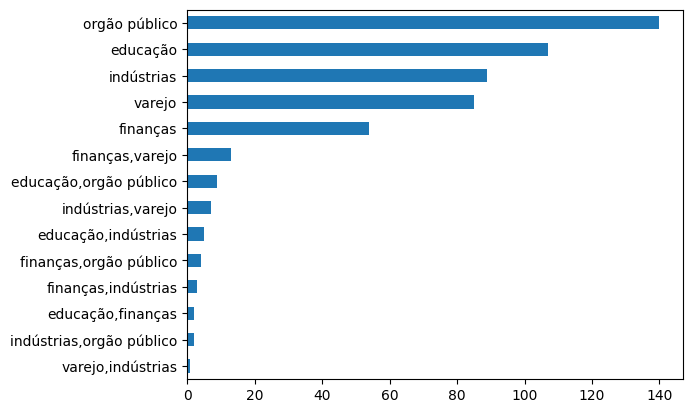

In [13]:
df.category.value_counts().sort_values().plot(kind = 'barh')

Algumas das categorias são coletivas, possuindo 2 classificações no máximo por texto, para solucionarmos esse problema iremos separar as categorias individuais

In [14]:
dummies = df['category'].str.get_dummies(sep=',')
df[dummies.columns] = dummies

Feito isso temos 5 colunas com 0s e 1s indicando se aquela sentença pertence a classe correspondente [1 para sim e 0 para não] - Esse método é chamado de **One-hot-encoding**

In [15]:
df.head(5)

,sentence,category,educação,finanças,indústrias,orgão público,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público,0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças,0,1,0,0,0
2,Então encontraremos na próxima aula.,educação,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,indústrias,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo",0,0,1,0,1


Removemos os caracteres especiais das colunas

In [16]:
df.columns = df.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.columns

Index(['sentence', 'category', 'educacao', 'financas', 'industrias',
       'orgao publico', 'varejo'],
      dtype='object')

Iremos remover a coluna *category*, não precisamos mais dela no momento

In [17]:
df.drop(columns=['category'], inplace=True)
df.head(5)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",0,1,0,0,0
2,Então encontraremos na próxima aula.,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...",0,0,1,0,1


In [18]:
df.apply(pd.Series.value_counts)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,NaN,398.0,445.0,414.0,366.0,415.0
1,NaN,123.0,76.0,107.0,155.0,106.0
Compre na web e saia com dinheiro no bolso!,1.0,NaN,NaN,NaN,NaN,NaN
O seu carrinho já tem 17 itens.,1.0,NaN,NaN,NaN,NaN,NaN
Temos preços especiais e retirada na loja.,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Você só pagará a tarifa por este serviço uma vez por mês.,1.0,NaN,NaN,NaN,NaN,NaN
programa de aprendizagem,1.0,NaN,NaN,NaN,NaN,NaN
É só ir ao caixa eletrônico do Itaú mais próximo com o seu cartão da conta corrente,1.0,NaN,NaN,NaN,NaN,NaN
É uma forma do investidor se programar para a realização dos seus objetivos.,1.0,NaN,NaN,NaN,NaN,NaN


Quantidade de valor por classe em estudo

<AxesSubplot: >

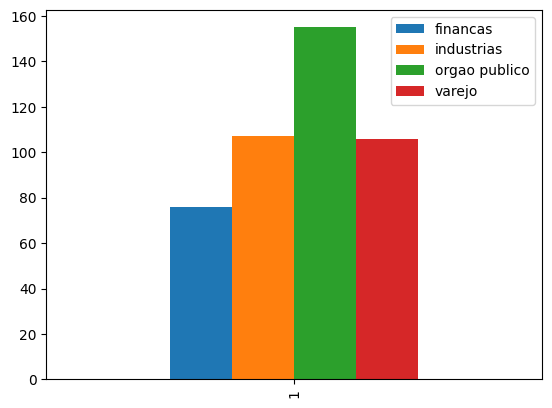

In [19]:
df.iloc[:,-4:].apply(pd.Series.value_counts).tail(1).plot(kind='bar')


## Tratamento do Texto e Processamento de Linguagem Natural

Nesta seção iremos tratar o texto de nosso dataset e transforma-lo em um padrão no qual poderemos gerar um classificador multi-label

In [20]:
#!pip install nltk

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import nltk

Estamos importando as stopwords (preposições) que atrapalham nosso processamento e modelagem

In [22]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a', 'à', 'ao', 'aos', 'aquela']

In [25]:
#Não há missing data in sentence
df.sentence.isna().sum()

0

In [26]:
import re
def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])\
        .lower().encode('ascii', errors='ignore').decode('utf-8'))    

    return data

In [27]:
#!pip install unidecode

In [28]:
import re
import unidecode

def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x:unidecode.unidecode(re.sub(r'[.,"\'-?:!;]', ' ', ' '.\
        join([word for word in x.split() if word not in (stopwords)])).lower()))    

    return data

In [29]:
df_clean = clean_text(df)

In [30]:
df_clean.drop(columns=["sentence"], inplace=True)
df_clean

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula
3,0,0,1,0,0,veja resultados categoria ofertas novo modelo ...
4,0,0,1,0,1,alem disso embalagem reutilizavel % recicl...
...,...,...,...,...,...,...
516,1,0,0,0,0,selecione local estudo curso encontros presen...
517,1,0,0,1,0,estudantes da rede municipal voltam as aulas e...
518,0,0,0,1,0,empresas orgaos publicos
519,0,0,0,1,0,dge - departamento gestao estrategica metas na...


Após limparmos o texto de stop words e deixa-lo em lowercase utilizaremos a ferramenta do TfidfVectorizer, o qual transformará as palavras do corpus (texto de sentence) em vetores que podem ser trabalhados.
Nesse contexto estaremos utilizando BOW (Bag of Words) e TF-IDF

Aqui esta um exemplo de aplicação:


In [31]:
df_clean.head(3)

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula


In [32]:
cleanTrain, cleanTest = train_test_split(df_clean, random_state=42, test_size=0.33, shuffle=True)

c:\Users\victo\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


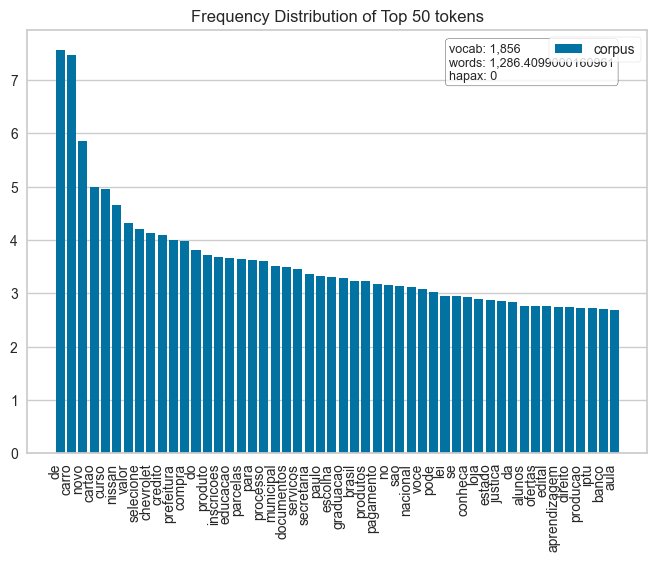

Aqui podemos ver a correlação entre as palavras e suas 'proximidades'


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


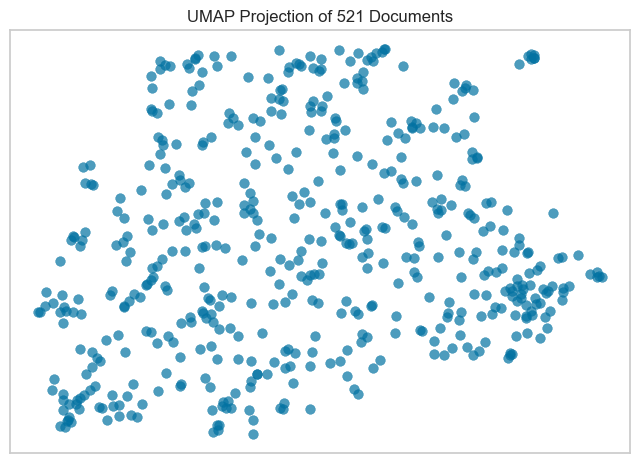

In [103]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
vector_train_text = vectorizer.fit_transform(df_clean["text_without_stopwords"])
#vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vector_train_text)
visualizer.show()

print("Aqui podemos ver a correlação entre as palavras e suas 'proximidades'")
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(metric="cosine")
umap.fit(vector_train_text)
umap.show()

vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])

In [34]:
df_clean.iloc[ : , :5].values

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=int64)

In [115]:


X_train, X_test, y_train, y_test = train_test_split(df['text_without_stopwords'], df_clean.iloc[ : , :5].values, random_state = 32, test_size=0.1)

#Usando TfIdf
tfidf = TfidfVectorizer(
    sublinear_tf= True,
    lowercase=True,
    analyzer='word',
    norm= 'l2', 
    ngram_range= (1,1),
    use_idf=True,
    binary=False,
    smooth_idf=True 
)

bow = TfidfVectorizer(
    binary=False,
    norm=None,
    use_idf=False,
    smooth_idf=False,
    lowercase=True,
    min_df= 1,
    max_features=None,
    ngram_range=(1,1)
)


X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)


## Modelagem

Nesta etapa iremos criar um Pipeline aplicar um modelo classificador no nosso conjunto de dados
Inicialmente iremos realizar multi classificações binárias utilizando modelos mais simples, a seguir iremos partir para um modelo mais complexto de classificação multilabel

### Multi-classificação binária

In [36]:
categories = df.columns[0:5]
categories

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')

Separando nosso conjunto de treino e teste

In [37]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [38]:
X_train = train.text_without_stopwords
X_test = test.text_without_stopwords

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('Treinando a categoria {}...'.format(category))
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


Treinando a categoria educacao...
Test accuracy is 0.7616279069767442
Treinando a categoria financas...
Test accuracy is 0.877906976744186
Treinando a categoria industrias...
Test accuracy is 0.8604651162790697
Treinando a categoria orgao publico...
Test accuracy is 0.872093023255814
Treinando a categoria varejo...
Test accuracy is 0.7790697674418605


In [40]:
X_test

507    tecnologia humana combina figura aluno  profes...
93       suas compras podem parceladas   x juros cartao 
6                                 veja condicoes compra 
245    atender clientes  manter limpeza loja  marcar ...
90     maquina lavar consul   kg branca  ciclo lavage...
                             ...                        
116    excelencia processos produtos  atraves envolvi...
45                      apresentacao   disciplina online
324          clique aqui ver processos relacionados trf 
16     temos ofertas promocoes imperdiveis  sempre co...
485                     sua cesta vazia  voltar compras 
Name: text_without_stopwords, Length: 172, dtype: object

### Classificação Multilabel

Vetorizando os valores textuais do nosso dataframe

In [42]:
[2, 5, 10]

[2, 5, 10]

Nesta seção estamos utilizando o estimador junto ao RandomizedSearchCV, assim obtermos os melhores hyperparametros do nosso modelo

In [90]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform

In [ ]:
model_grid = ExtraTreesClassifier()
param_grid = {'n_estimators': [500,1000,2000],
            'min_samples_split': [2, 5, 10]}     
clf_cv = GridSearchCV(estimator = model_grid,  param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='f1_weighted')
search = clf_cv.fit(X_train_counts, y_train)
best_params_extra_trees = search.best_params_
best_params_extra_trees

Modelos utilizando TFIDF

In [105]:
model_one = OneVsRestClassifier(xgb.XGBClassifier(n_estimators=100)).fit(X_train_counts, y_train)

In [64]:
rf = ExtraTreesClassifier(**best_params)
rf.fit(X_train_counts, y_train)
rf

ExtraTreesClassifier(n_estimators=1000)

Modelos utilizando BOW

In [116]:
model_bow = OneVsRestClassifier(xgb.XGBClassifier(n_estimators=100)).fit(X_train_bow, y_train)

In [117]:
rf_bow = ExtraTreesClassifier(n_estimators=1000).fit(X_train_bow, y_train)

Predição utilizando os modelos criados

In [119]:
predicted_labels_one = model_one.predict(X_test_counts)
predicted_labels_one_bow = model_bow.predict(X_test_bow)

In [118]:
predicted_labels = rf.predict(X_test_counts)
predicted_labels_bow = rf.predict(X_test_bow)

#### Métricas

Utilizando principalmente o F1-Score como medida de desempenho de nosso modelo, essa métrica é baseada na média harmônica entre Recall e Precision no qual também estaremos analisando nesse problema de classificação multitarget, por ser um problema com mais de uma classe precisamos da média dessas métricas.

In [108]:
from sklearn.metrics import average_precision_score


def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))

Matriz de Confusão para ExtraTreesClassifier

In [109]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(predicted_labels, y_test))

[[[41  5]
  [ 1  6]]

 [[44  5]
  [ 1  3]]

 [[41  3]
  [ 0  9]]

 [[30  4]
  [10  9]]

 [[38  6]
  [ 1  8]]]


Matriz de Confusão para OneVsRestClassifier

In [110]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(predicted_labels_one, y_test))

[[[40  6]
  [ 2  5]]

 [[42  6]
  [ 3  2]]

 [[40  4]
  [ 1  8]]

 [[38 10]
  [ 2  3]]

 [[38  7]
  [ 1  7]]]


Métricas de Avaliação de ExtraTreesClassifier

In [121]:
#TFIDF
print_evaluation_scores(y_test,predicted_labels)

Accuracy:  31
F1-score macro:  0.6563923395445135
F1-score micro:  0.6603773584905661
F1-score weighted:  0.6667358285143143
Precision macro:  0.5537232924583967
Precision micro:  0.5268068206462806
Precision weighted:  0.565601068926926


In [122]:
#BOW
print_evaluation_scores(y_test,predicted_labels_bow)

Accuracy:  31
F1-score macro:  0.6563923395445135
F1-score micro:  0.6603773584905661
F1-score weighted:  0.6667358285143143
Precision macro:  0.5537232924583967
Precision micro:  0.5268068206462806
Precision weighted:  0.565601068926926


Métricas de Avaliação de OneVsRestClassifier

In [112]:
#TFIDF
print_evaluation_scores(y_test,predicted_labels_one)

Accuracy:  20
F1-score macro:  0.518969918969919
F1-score micro:  0.5434782608695653
F1-score weighted:  0.5337574303091546
Precision macro:  0.4431741930326837
Precision micro:  0.4414654215622489
Precision weighted:  0.4614832801478865


In [123]:
#BOW
print_evaluation_scores(y_test,predicted_labels_one_bow)

Accuracy:  22
F1-score macro:  0.5518128654970761
F1-score micro:  0.5555555555555556
F1-score weighted:  0.5509175236942931
Precision macro:  0.47667948403797455
Precision micro:  0.46127399154196486
Precision weighted:  0.48628125290454505


A partir daqui usaremos os testes do melhor classificador

C:\Users\victo\AppData\Local\Temp\ipykernel_7056\2494917428.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


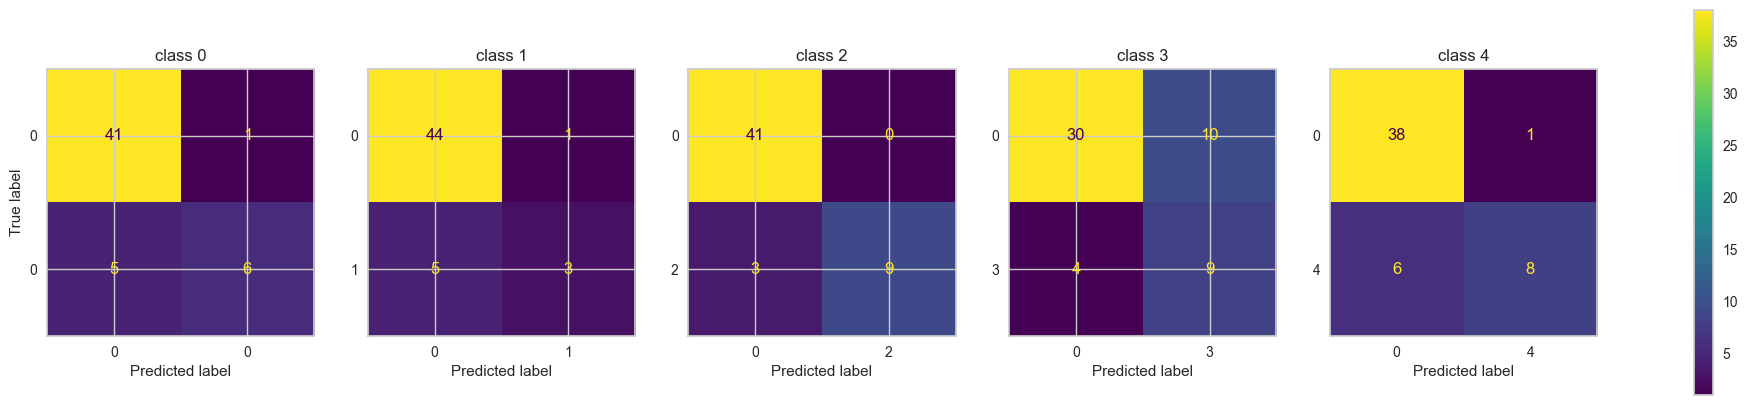

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay


f, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.ravel()
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   predicted_labels[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
f.colorbar(disp.im_, ax=axes)
plt.grid(b=None)
plt.show()


Aqui podemos realizar um teste com um input arbitrário e nosso modelo irá classificá-lo

In [68]:
def input_to_class(predictor, entrada):
    singular = tfidf.transform(pd.Series([entrada]))
    resultado = predictor.predict(singular)
    colunas = df_clean.iloc[:, 0:5].columns
    for i in range(len(colunas)):
        if (resultado[0][i] == 1):
            print(colunas[i])

In [73]:
colunas = df_clean.iloc[:, 0:5].columns
colunas

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')

In [79]:
entrada = input()
input_to_class(rf, entrada)

orgao publico


Usando um exemplo da descrição do problema:

In [89]:
entrada = 'Curso de Técnico em Segurança do Trabalho por 32x R$ 161,03.'
input_to_class(rf, entrada)

educacao


Ferramenta para a construção e execução de um modelo completo: